
# 📈 03 — Modelagem de **IMDB_Rating** (Regressão)

Objetivo: construir e avaliar modelos para **prever a nota IMDb** a partir das variáveis estruturadas do dataset
e, opcionalmente, do texto **Overview** (TF‑IDF). Ao final, salvar o modelo em `.pkl`.

> **Entrada:** `data/movies.csv`  
> **Saída:** `models/imdb_model.pkl` (pipeline completo: pré-processamento + estimador)


In [1]:

# Imports
import warnings
warnings.filterwarnings("ignore")

import re, os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



## 1) Carregar dados e preparar features básicas
- Parse de `Runtime` → minutos
- Parse de `Gross` → número e `log1p`
- `Released_Year` → inteiro
- `Genre_Primary` → primeiro gênero da lista


In [2]:

DATA_PATH = "../data/movies.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head(3)


Shape: (999, 16)


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"


In [3]:

def parse_runtime_to_minutes(runtime):
    if pd.isna(runtime):
        return np.nan
    if isinstance(runtime, (int, float)):
        return int(runtime) if runtime > 0 else np.nan
    m = re.search(r"(\d+)", str(runtime))
    return int(m.group(1)) if m else np.nan

def parse_gross_to_number(gross):
    if gross is None:
        return np.nan
    if isinstance(gross, (int, float)):
        return float(gross)
    s = str(gross).strip()
    if s == "":
        return np.nan
    s = s.replace(",", "").replace(".", "")
    return float(s) if s.isdigit() else np.nan

def split_genre(genre):
    if pd.isna(genre): return []
    return [g.strip() for g in str(genre).split(",") if g.strip()]

dfc = df.copy()
dfc["Runtime_min"] = dfc["Runtime"].apply(parse_runtime_to_minutes)
dfc["Gross_num"]   = dfc["Gross"].apply(parse_gross_to_number)
dfc["Gross_log1p"] = np.log1p(dfc["Gross_num"])
dfc["Released_Year_int"] = pd.to_numeric(dfc["Released_Year"], errors="coerce").astype("Int64")
dfc["Genre_List"] = dfc["Genre"].apply(split_genre)
dfc["Genre_Primary"] = dfc["Genre_List"].apply(lambda lst: lst[0] if lst else np.nan)

# Indicadores de missing (podem carregar sinal)
dfc["Gross_isna"] = dfc["Gross_num"].isna().astype(int)
dfc["Meta_isna"]  = dfc["Meta_score"].isna().astype(int)

# Garantir texto não-nulo para TF-IDF (se usado)
dfc["Overview"] = dfc["Overview"].fillna("")
dfc.head(5)


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,...,No_of_Votes,Gross,Runtime_min,Gross_num,Gross_log1p,Released_Year_int,Genre_List,Genre_Primary,Gross_isna,Meta_isna
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,...,1620367,"134,966,411",175,134966411.0,18.720537,1972,"[Crime, Drama]",Crime,0,0
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,...,2303232,"534,858,444",152,534858444.0,20.097513,2008,"[Action, Crime, Drama]",Action,0,0
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,...,1129952,"57,300,000",202,57300000.0,17.863811,1974,"[Crime, Drama]",Crime,0,0
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,...,689845,"4,360,000",96,4360000.0,15.287983,1957,"[Crime, Drama]",Crime,0,0
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,...,1642758,"377,845,905",201,377845905.0,19.749997,2003,"[Action, Adventure, Drama]",Action,0,0



## 2) Definir **cenário** de modelagem
- `"post_release"`: pode usar `Meta_score` e `Gross` (contexto pós-lançamento).
- `"early_stage"`: **não** usa `Gross` e (opcionalmente) não usa `Meta_score` (cenário antes da crítica).  
Você pode alternar a flag abaixo para comparar.


In [4]:

SCENARIO = "post_release"   # opções: "post_release" | "early_stage"

num_base = ["No_of_Votes", "Runtime_min", "Released_Year_int"]
cat_cols = ["Genre", "Certificate", "Director", "Star1", "Star2", "Star3", "Star4"]
text_col = "Overview"   # opcional (TF-IDF)

if SCENARIO == "post_release":
    num_cols = num_base + ["Meta_score", "Gross_log1p", "Gross_isna", "Meta_isna"]
else:
    # early_stage: exclui Gross; opcional: excluir Meta_score também (comente conforme desejar)
    num_cols = num_base + ["Meta_isna"]
    # Se quiser manter Meta_score (pós-crítica), descomente:
    # num_cols += ["Meta_score"]
    
print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)
print("Texto:", text_col)


Numéricas: ['No_of_Votes', 'Runtime_min', 'Released_Year_int', 'Meta_score', 'Gross_log1p', 'Gross_isna', 'Meta_isna']
Categóricas: ['Genre', 'Certificate', 'Director', 'Star1', 'Star2', 'Star3', 'Star4']
Texto: Overview



## 3) Conjunto de treino/teste


In [5]:

# Alvo
y = dfc["IMDB_Rating"].astype(float)

# Features como DataFrame para o ColumnTransformer selecionar por nome
X = dfc[num_cols + cat_cols + [text_col]].copy()

# Split (sem estratificação; é regressão)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (799, 15)  Test: (200, 15)



## 4) Pré-processamento & Modelos
- **Numéricas**: `SimpleImputer(median)`
- **Categóricas**: `SimpleImputer(most_frequent)` + `OneHotEncoder(handle_unknown="ignore")`
- **Texto**: `TfidfVectorizer(max_features=5000, ngram_range=(1,2))` (opcional, pode reduzir para datasets pequenos)


In [7]:

use_text = True  # troque para False se quiser comparar sem Overview

num_pipe = SimpleImputer(strategy="median")
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer com (opcional) TF-IDF no texto
if use_text:
    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
            ("txt", TfidfVectorizer(max_features=5000, ngram_range=(1,2)), text_col),
        ],
        remainder="drop"
    )
else:
    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop"
    )

# Modelos candidatos
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}



## 5) Treino, avaliação e comparação
Métricas:
- **RMSE** (raiz do erro quadrático médio)
- **MAE** (erro absoluto médio)
- **R²**


In [8]:

def evaluate_regression(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

results = []

for name, est in models.items():
    pipe = Pipeline([("pre", pre), ("est", est)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse, mae, r2 = evaluate_regression(y_test, preds)
    results.append((name, rmse, mae, r2, pipe))

res_df = pd.DataFrame(results, columns=["modelo","rmse","mae","r2","pipeline"]).sort_values("rmse")
res_df[["modelo","rmse","mae","r2"]]


,modelo,rmse,mae,r2
2,GradientBoosting,0.207275,0.165308,0.345517
1,RandomForest,0.209182,0.163342,0.333417
0,LinearRegression,0.209501,0.165513,0.331386



### Plot: Previsto vs Real (melhor modelo)


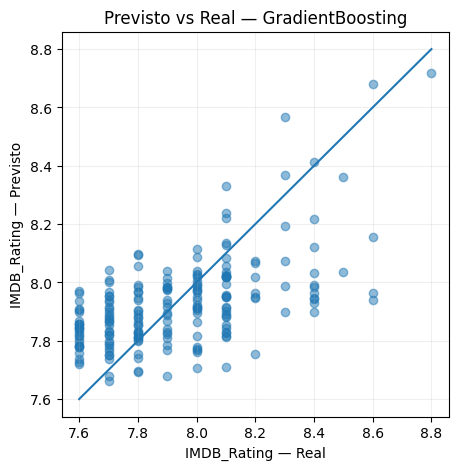

GradientBoosting — RMSE: 0.207 | MAE: 0.165 | R²: 0.346


In [9]:

best_row = res_df.iloc[0]
best_name = best_row["modelo"]
best_pipe = best_row["pipeline"]
best_preds = best_pipe.predict(X_test)

fig = plt.figure(figsize=(5,5))
plt.scatter(y_test, best_preds, alpha=0.5)
plt.xlabel("IMDB_Rating — Real")
plt.ylabel("IMDB_Rating — Previsto")
plt.title(f"Previsto vs Real — {best_name}")
# linha y=x
mn, mx = float(min(y_test.min(), best_preds.min())), float(max(y_test.max(), best_preds.max()))
plt.plot([mn, mx], [mn, mx])
plt.grid(True, alpha=0.2)
plt.show()

rmse, mae, r2 = evaluate_regression(y_test, best_preds)
print(f"{best_name} — RMSE: {rmse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}")



### Plot: Resíduos (melhor modelo)


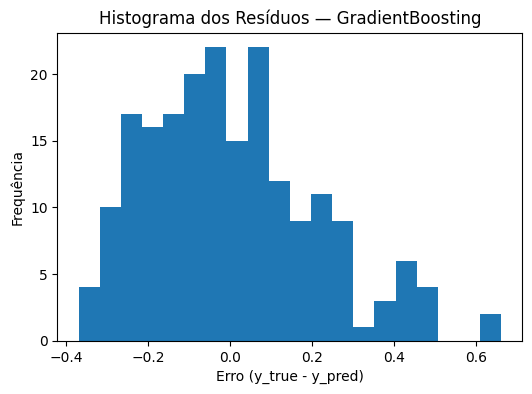

In [10]:

residuals = y_test - best_preds
fig = plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20)
plt.title(f"Histograma dos Resíduos — {best_name}")
plt.xlabel("Erro (y_true - y_pred)")
plt.ylabel("Frequência")
plt.show()



## 6) Validação cruzada (K-Fold)
Usamos KFold simples (regressão), embarcando o pré-processamento dentro do pipeline.


In [11]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_pipe, X, y, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1)
print("CV RMSE (folds):", np.round(-cv_scores, 3))
print("CV RMSE (média):", round((-cv_scores).mean(), 3))


CV RMSE (folds): [0.207 0.196 0.2   0.184 0.19 ]
CV RMSE (média): 0.196



## 7) Salvar pipeline treinado (`.pkl`)
Salvamos **pré-processamento + modelo** para ser usado em produção/inferência.


In [12]:

os.makedirs("models", exist_ok=True)
bundle_path = "models/imdb_model.pkl"
with open(bundle_path, "wb") as f:
    pickle.dump(best_pipe, f)
print("Modelo salvo em:", bundle_path)


Modelo salvo em: models/imdb_model.pkl



## 8) Inferência com um exemplo (dado do enunciado)


In [13]:

sample = {
 'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'
}

# Transformar sample no mesmo esquema de colunas usadas pelo pipeline
def sample_to_features(d):
    row = {}
    row["No_of_Votes"] = d.get("No_of_Votes", np.nan)
    row["Runtime_min"] = parse_runtime_to_minutes(d.get("Runtime", np.nan))
    row["Released_Year_int"] = pd.to_numeric(d.get("Released_Year", np.nan), errors="coerce")
    row["Meta_score"] = d.get("Meta_score", np.nan)
    row["Gross_num"] = parse_gross_to_number(d.get("Gross", None))
    row["Gross_log1p"] = np.log1p(row["Gross_num"]) if pd.notna(row["Gross_num"]) else np.nan
    row["Gross_isna"] = int(pd.isna(row["Gross_num"]))
    row["Meta_isna"] = int(pd.isna(row["Meta_score"]))
    row["Genre"] = d.get("Genre", "")
    row["Certificate"] = d.get("Certificate", "")
    row["Director"] = d.get("Director", "")
    row["Star1"] = d.get("Star1", "")
    row["Star2"] = d.get("Star2", "")
    row["Star3"] = d.get("Star3", "")
    row["Star4"] = d.get("Star4", "")
    row["Overview"] = d.get("Overview", "")
    return row

row = sample_to_features(sample)
X_one = pd.DataFrame([row])

yhat = best_pipe.predict(X_one)[0]
print(f"Predição IMDB_Rating: {yhat:.2f}")


Predição IMDB_Rating: 8.65



## 9) Notas
- Compare **cenários** alternando a flag `SCENARIO` e a variável `use_text`.
- Para evitar *data leakage*, só use `Gross`/`Meta_score` no cenário **pós-lançamento**.
- O `RandomForest` costuma performar bem neste tipo de dado tabular; teste também Gradient Boosting e (opcionalmente) XGBoost/LightGBM.
- Ajuste `max_features` do TF‑IDF para controlar dimensionalidade do texto.
